In [3]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import time

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

***
# MLP with Normalization and Log Transformation 7-ahead

***

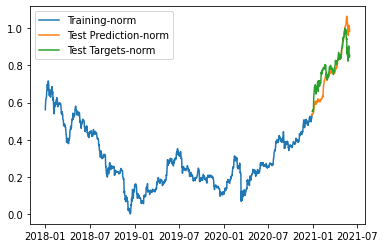

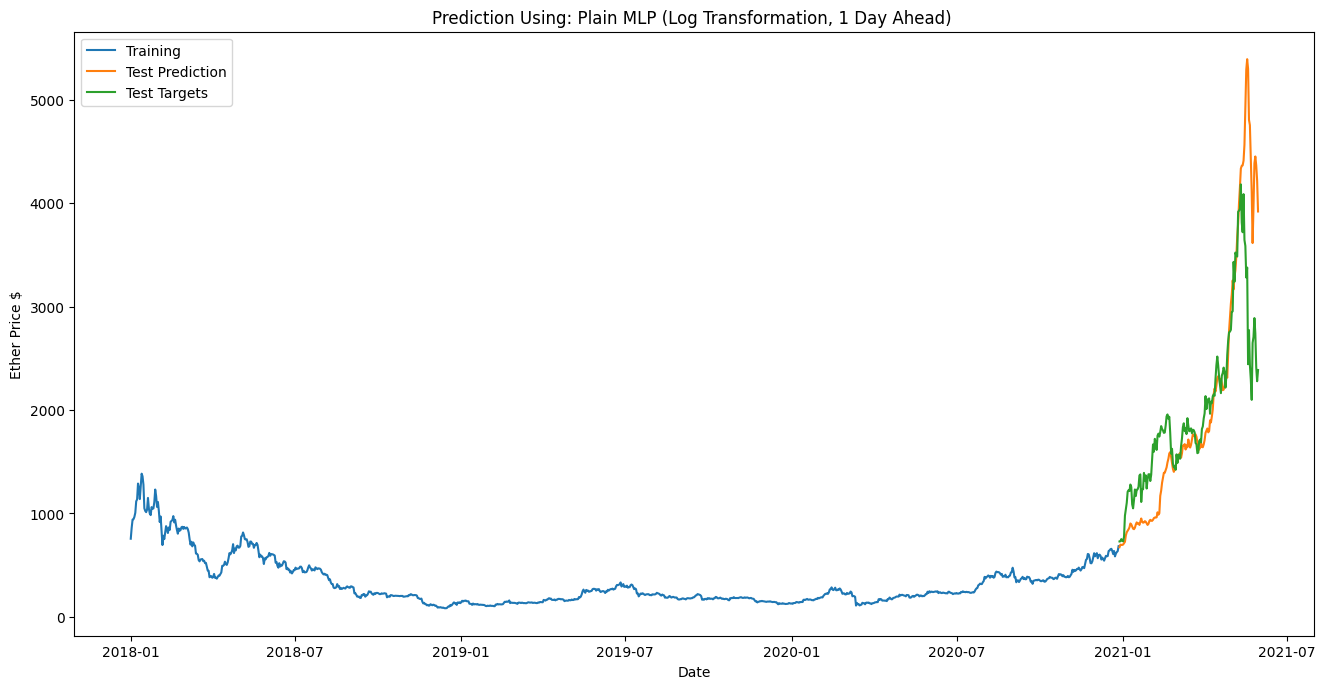

Total RMSE is:  666.1838418427076
Total APE is:  20.387480669752552
Runtime of the program is 322.7782726287842


In [18]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)


scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

# convert history into inputs and outputs
n_input = 14
n_out = 1

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# flatten input for MLP
n_input_nn=train_x.shape[1] * train_x.shape[2]
train_x = train_x.reshape((train_x.shape[0], n_input_nn))

# Define model
model= Sequential()
model.add(Dense(700, activation='relu', input_dim=n_input_nn))
model.add(Dense(500, activation='relu', input_dim=700))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')
model.fit(train_x, train_y, epochs=2000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = input_x.reshape((1, input_x.shape[0] * input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
#s_scores = ', '.join(['%.1f' % s for s in scores])
#print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs

y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Plain MLP (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# Multi-headed MLP with Normalization and Log Transformation 1-ahead
***

MLP Multivariate: [0.141] 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.2


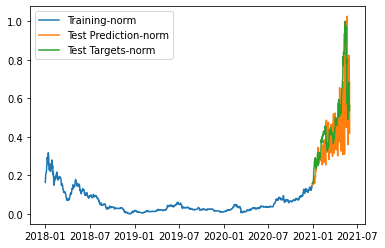

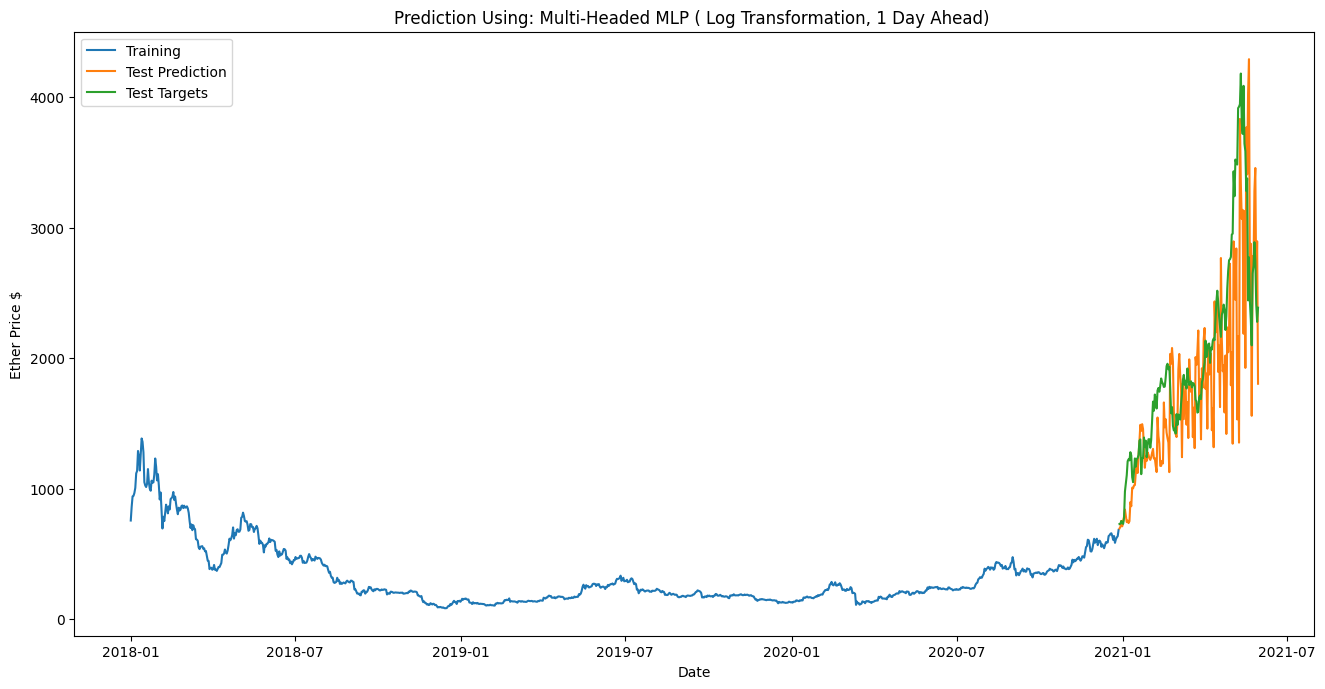

Total RMSE is:  576.7237904121394
Total APE is:  18.334021803669284
Runtime of the program is 174.3493368625641


In [6]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
import tensorflow as tf

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
#df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 7

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# separate input data
X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# first input model
visible= [Input(shape=(n_input,)) for i in range(train_x.shape[2])]
dense=[Dense(50, activation='relu')(visible[i]) for i in range(train_x.shape[2])]
#Drops=[Dropout(0.5)(dense[i]) for i in range(train_x.shape[2])]

# merge input models
merge = concatenate([dense[i] for i in range(train_x.shape[2])])
output = Dense(n_out)(merge)
model = Model(inputs=[visible[i] for i in range(train_x.shape[2])], outputs=output)
model.compile(optimizer='Adam', loss='mse')
# fit model
model.fit(X, train_y, epochs=2000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    x=[input_x[:, i].reshape((1, n_input)) for i in range(train_x.shape[2])] 
    yhat = model.predict(x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])
y_predrev=(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

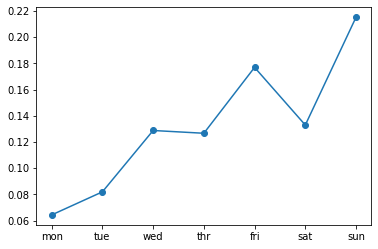

In [7]:
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
plt.plot(days, scores, marker='o', label='MLP')
plt.show()   

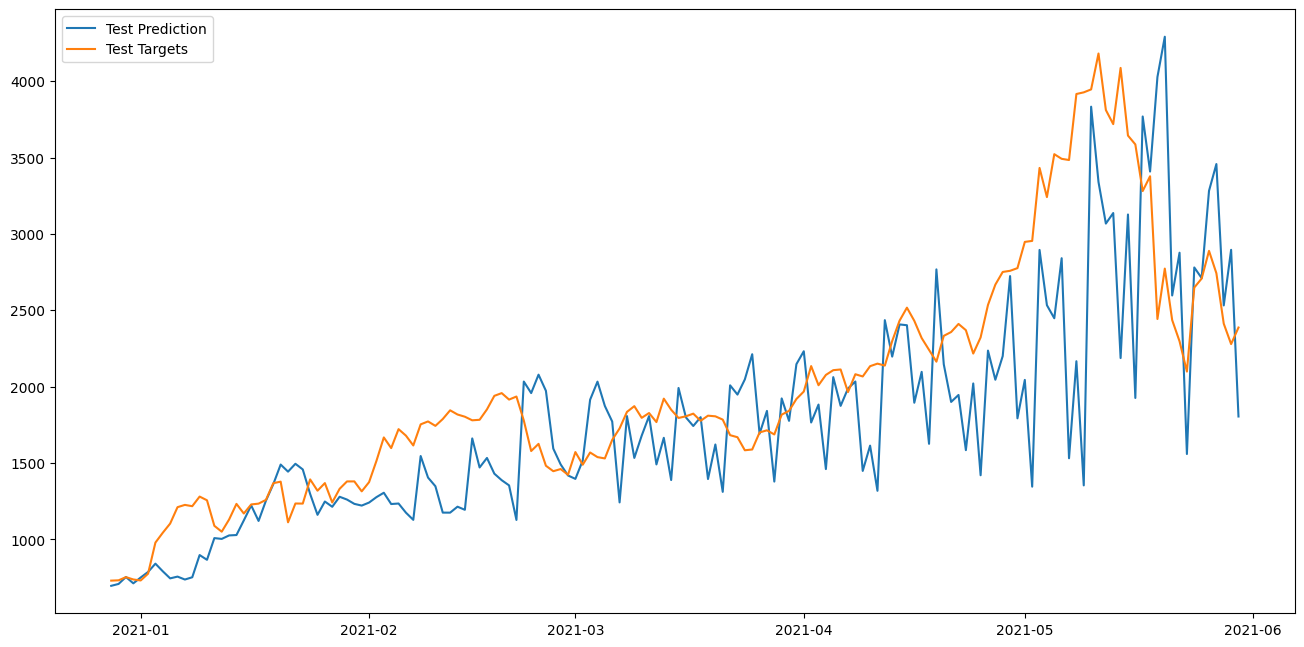

Total RMSE is:  576.7237904121394
Total APE is:  18.334021803669284


In [42]:
y_pred_shift=pd.Series(y_predrev).shift(0)
plt.figure(figsize=(16,8), dpi=100)
plt.plot(test_index, y_pred_shift, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.legend()
plt.show()
rmse = np.sqrt(np.mean((y_testrev-y_pred_shift)**2))
ape = np.mean(np.abs((y_testrev-y_pred_shift)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)

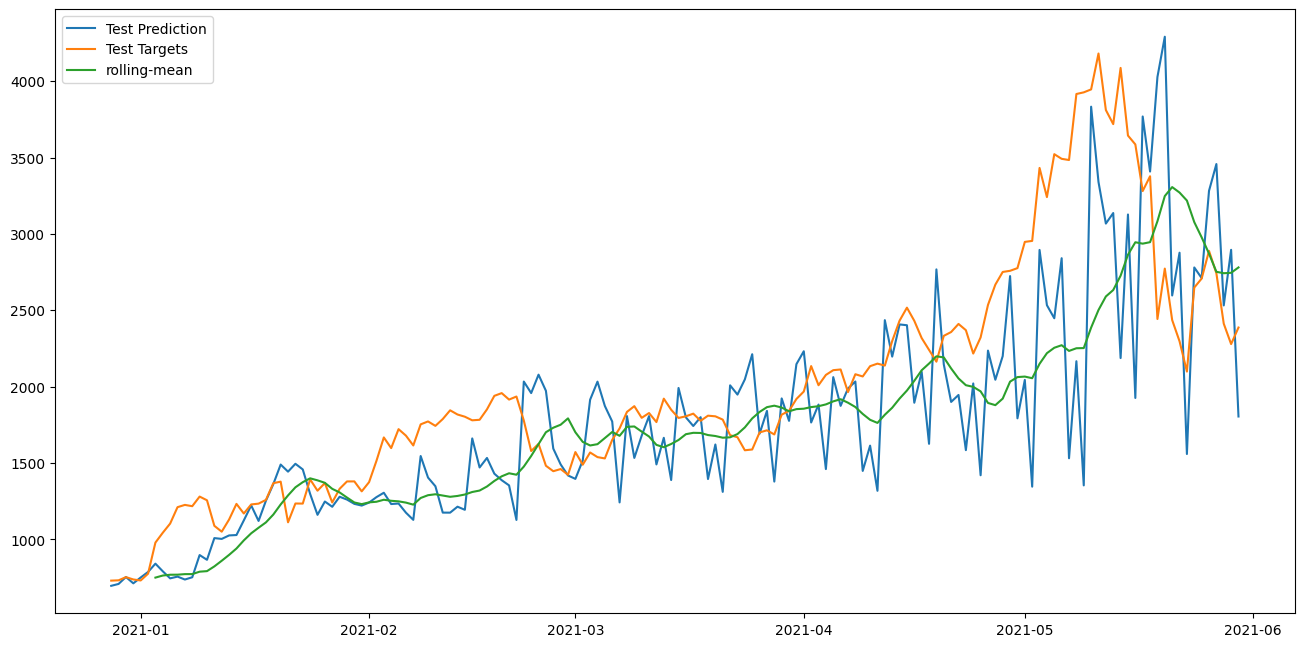

Total PredRMSE is:  576.7237904121394
Total PredAPE is:  18.334021803669284
Total RolmRMSE is:  534.1399774649675
Total RolmAPE is:  17.51947871883023


In [43]:
# Rolling Mean
rolling = pd.Series(y_predrev).rolling(window=7)
rolling_mean = rolling.mean()
rolling_mean=rolling_mean.shift(0)

plt.figure(figsize=(16,8), dpi=100)
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, rolling_mean, label='rolling-mean')

plt.legend()
plt.show()

rmsePred = np.sqrt(np.mean((y_testrev-y_predrev)**2))
apePred = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total PredRMSE is: ' , rmsePred)
print('Total PredAPE is: ' , apePred)

rmseRolm = np.sqrt(np.mean((y_testrev-rolling_mean)**2))
apeRolm = np.mean(np.abs((y_testrev-rolling_mean)*100/y_testrev))
print('Total RolmRMSE is: ' , rmseRolm)
print('Total RolmAPE is: ' , apeRolm)

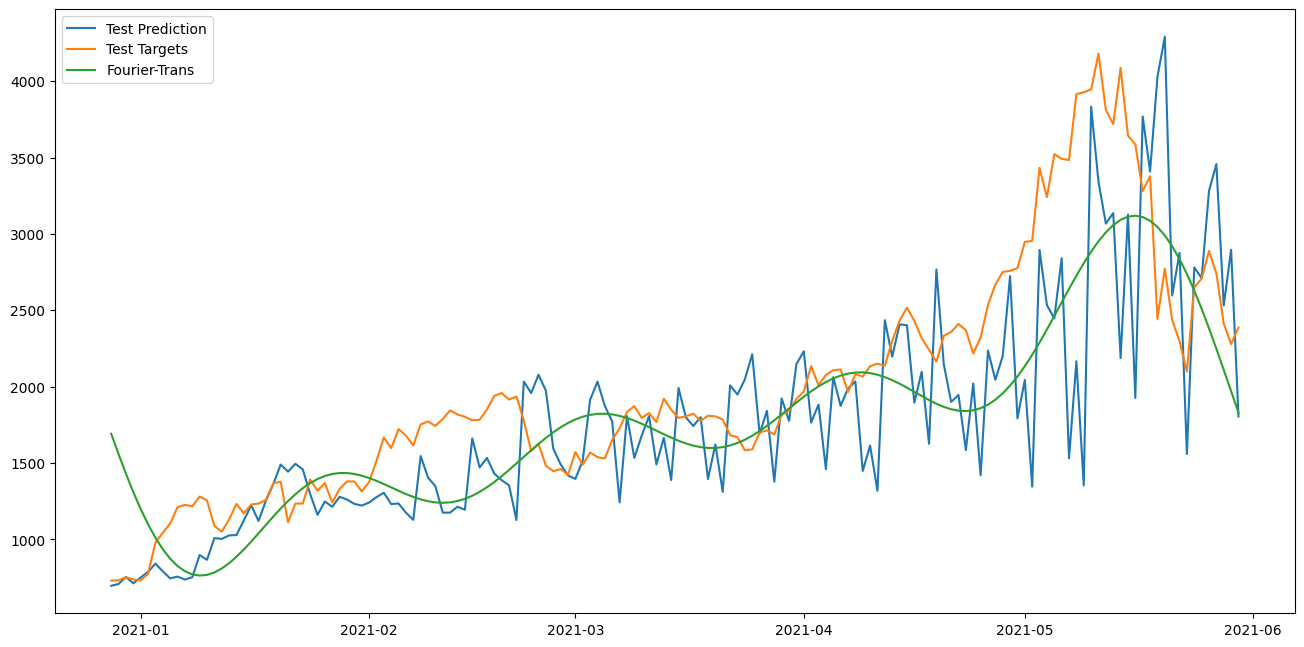

Total PredRMSE is:  576.7237904121394
Total PredAPE is:  18.334021803669284
Total FT_RMSE is:  453.5232099256446
Total FT_APE is:  18.61323441475712


In [80]:
# Fourier Transform
#https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    Denoises data using the fast fourier transform.
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)      
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """

    n = len(x)
    # compute the fft
    fft = np.fft.fft(x, n)
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    if to_real:
        clean_data = clean_data.real
    return clean_data

x=y_predrev
n_components=1999900
FT=fft_denoiser(y_predrev, n_components, to_real=True)
FT=pd.Series(FT).shift(0)
plt.figure(figsize=(16,8), dpi=100)
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, FT, label='Fourier-Trans')

plt.legend()
plt.show()

rmsePred = np.sqrt(np.mean((y_testrev-y_predrev)**2))
apePred = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total PredRMSE is: ' , rmsePred)
print('Total PredAPE is: ' , apePred)

rmseFT = np.sqrt(np.mean((y_testrev-FT)**2))
apeFT = np.mean(np.abs((y_testrev-FT)*100/y_testrev))
print('Total FT_RMSE is: ' , rmseFT)
print('Total FT_APE is: ' , apeFT)

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


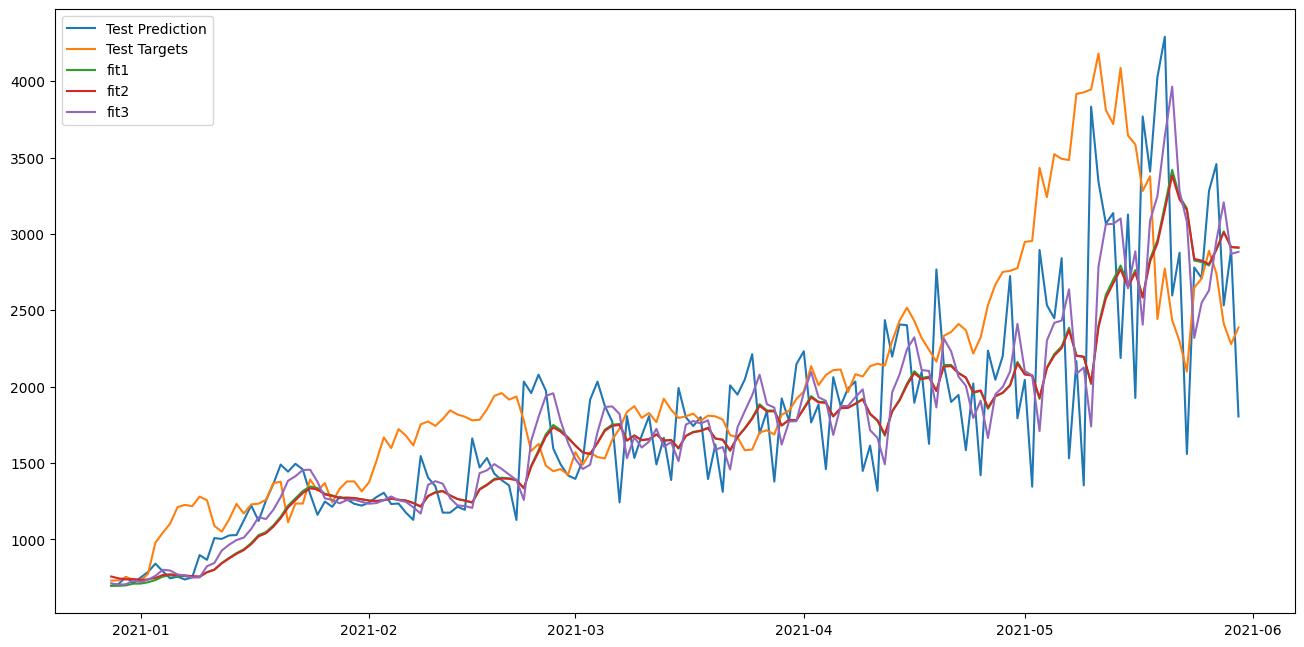

Total PredRMSE is:  576.7237904121394
Total PredAPE is:  18.334021803669284
Total F1_RMSE is:  546.7663436053236
Total F1_APE is:  17.735130219305834
Total F2_RMSE is:  547.9118977953717
Total F2_APE is:  17.59722048989195
Total F3_RMSE is:  547.9297637365964
Total F3_APE is:  18.06604686120915


In [48]:
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
model = SimpleExpSmoothing(np.asarray(y_predrev))
fit1 = model.fit()
fit1.fittedvalues=pd.Series(fit1.fittedvalues).shift(0)
fit2 = model.fit(smoothing_level=.2)
fit2.fittedvalues=pd.Series(fit2.fittedvalues).shift(0)
fit3 = model.fit(smoothing_level=.5)
fit3.fittedvalues=pd.Series(fit3.fittedvalues).shift(0)
plt.figure(figsize=(16,8), dpi=100)
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, fit1.fittedvalues, label='fit1')
plt.plot(test_index, fit2.fittedvalues, label='fit2')
plt.plot(test_index, fit3.fittedvalues, label='fit3')

plt.legend()
plt.show()

rmsePred = np.sqrt(np.mean((y_testrev-y_predrev)**2))
apePred = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total PredRMSE is: ' , rmsePred)
print('Total PredAPE is: ' , apePred)

rmseF1 = np.sqrt(np.mean((y_testrev-fit1.fittedvalues)**2))
apeF1 = np.mean(np.abs((y_testrev-fit1.fittedvalues)*100/y_testrev))
print('Total F1_RMSE is: ' , rmseF1)
print('Total F1_APE is: ' , apeF1)

rmseF2 = np.sqrt(np.mean((y_testrev-fit2.fittedvalues)**2))
apeF2 = np.mean(np.abs((y_testrev-fit2.fittedvalues)*100/y_testrev))
print('Total F2_RMSE is: ' , rmseF2)
print('Total F2_APE is: ' , apeF2)

rmseF3 = np.sqrt(np.mean((y_testrev-fit3.fittedvalues)**2))
apeF3 = np.mean(np.abs((y_testrev-fit3.fittedvalues)*100/y_testrev))
print('Total F3_RMSE is: ' , rmseF3)
print('Total F3_APE is: ' , apeF3)

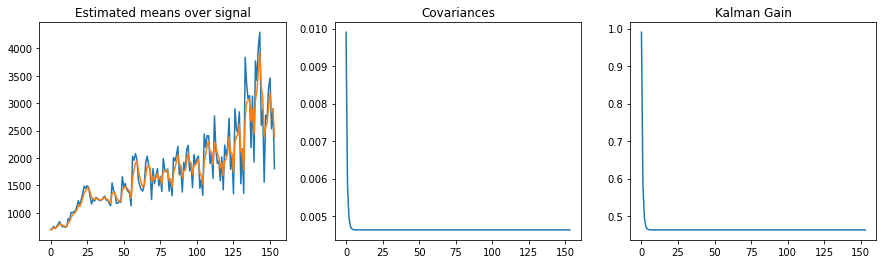

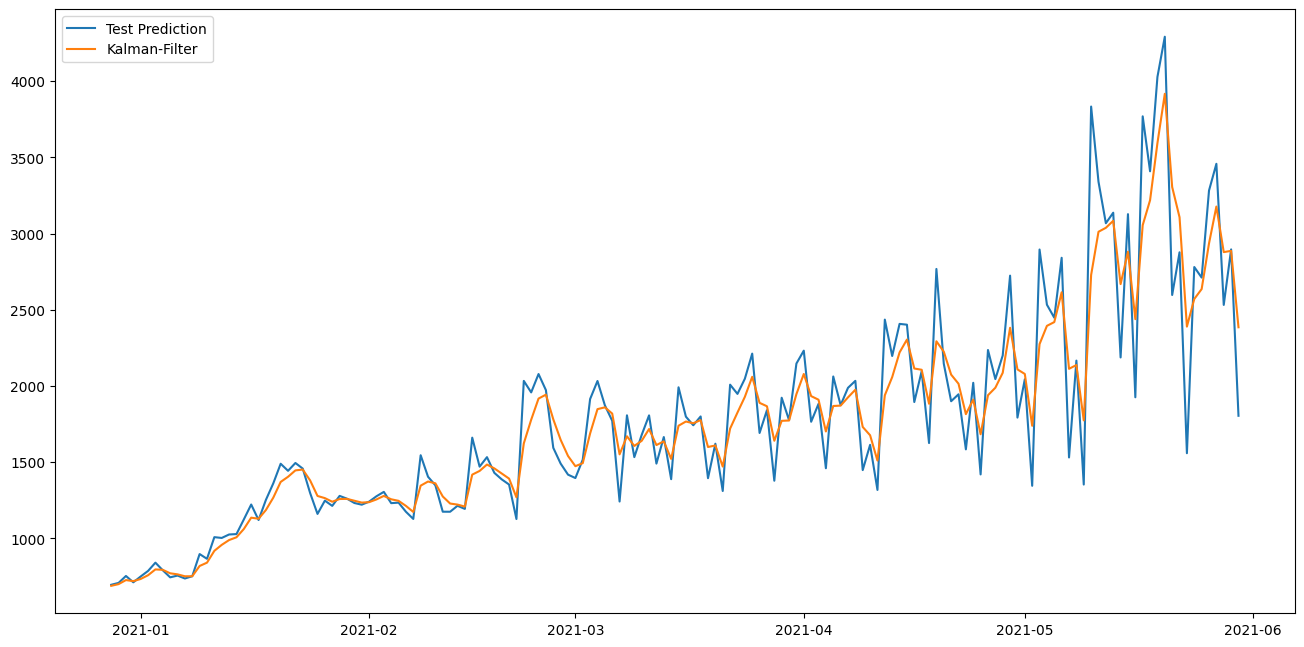

In [46]:
# Kalman Filter
# https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d
import numpy as np
import matplotlib.pyplot as plt
from kalmanfilter import KalmanFilter

# -----------------------------------------------------------------------------

if __name__ == "__main__":
    # -------------------------------------------------------------------------
    # generate noisy observations
    Z = y_predrev

    # kalman settings
    A = np.expand_dims(np.ones((len(Z),1)), axis=1) # transition matrix
    xk = np.array([[1]]) # initial mean estimate

    B = np.expand_dims(np.zeros((len(Z),1)), axis=1) # control-input matrix
    U = np.zeros((len(Z), 1)) # control-input vector

    Pk = np.array([[1]]) # initial covariance estimate
    Q = np.ones((len(Z))) * 0.004 # process noise covariance

    H = A.copy() # observation matrix
    R = np.ones((len(Z))) * 0.01 # measurement noise covariance

    # -------------------------------------------------------------------------
    # run Kalman filter
    kf = KalmanFilter(A=A, xk=xk, B=B, Pk=Pk, H=H, Q=Q, R=R)
    states, errors = kf.filter(Z=Z, U=U)
    kalman_gain = np.stack([val.item() for val in kf.kalman_gains])

    # as a flat array
    states = np.stack([val.item() for val in states])
    errors = np.stack([val.item() for val in errors])

    # plot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    ax[0].plot(Z)
    ax[0].plot(states)
    ax[0].set_title('Estimated means over signal')

    ax[1].plot(errors)
    ax[1].set_title('Covariances')

    ax[2].plot(kalman_gain)
    ax[2].set_title('Kalman Gain')

    plt.show()
    
plt.figure(figsize=(16,8), dpi=100)
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, states, label='Kalman-Filter')


plt.legend()
plt.show()

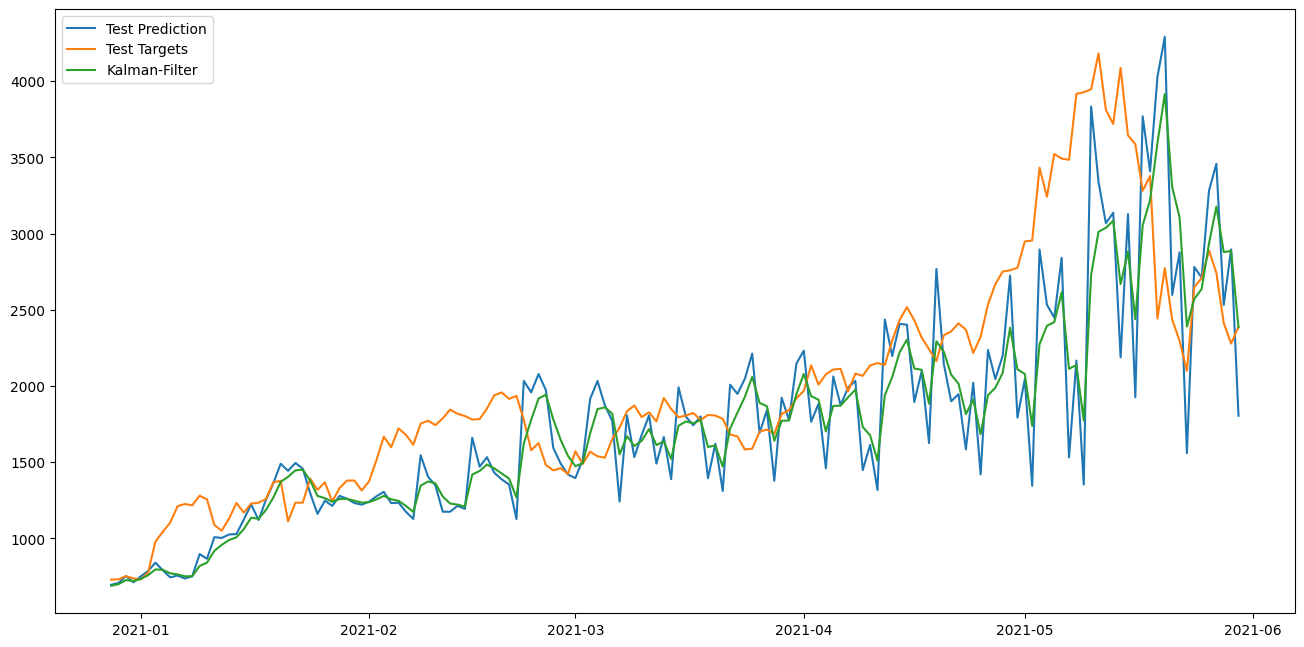

Total PredRMSE is:  576.7237904121394
Total PredAPE is:  18.334021803669284
Total KF-RMSE is:  515.9321298553385
Total KF-mAPE is:  16.851394968676704
Total Shifted-KF-RMSE is:  378.4955325361273
Total Shifted-KF-mAPE is:  12.852090237943557


In [47]:
states_shift=pd.Series(states).shift(-7)
plt.figure(figsize=(16,8), dpi=100)
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, states, label='Kalman-Filter')
#plt.plot(test_index, states_shift, label='shifted-Kalman-Filter')

plt.legend()
plt.show()

rmsePred = np.sqrt(np.mean((y_testrev-y_predrev)**2))
apePred = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total PredRMSE is: ' , rmsePred)
print('Total PredAPE is: ' , apePred)

rmseKF = np.sqrt(np.mean((y_testrev-states)**2))
apeKF = np.mean(np.abs((y_testrev-states)*100/y_testrev))
print('Total KF-RMSE is: ' , rmseKF)
print('Total KF-mAPE is: ' , apeKF)

rmseSKF = np.sqrt(np.mean((y_testrev-states_shift)**2))
apeSKF = np.mean(np.abs((y_testrev-states_shift)*100/y_testrev))
print('Total Shifted-KF-RMSE is: ' , rmseSKF)
print('Total Shifted-KF-mAPE is: ' , apeSKF)

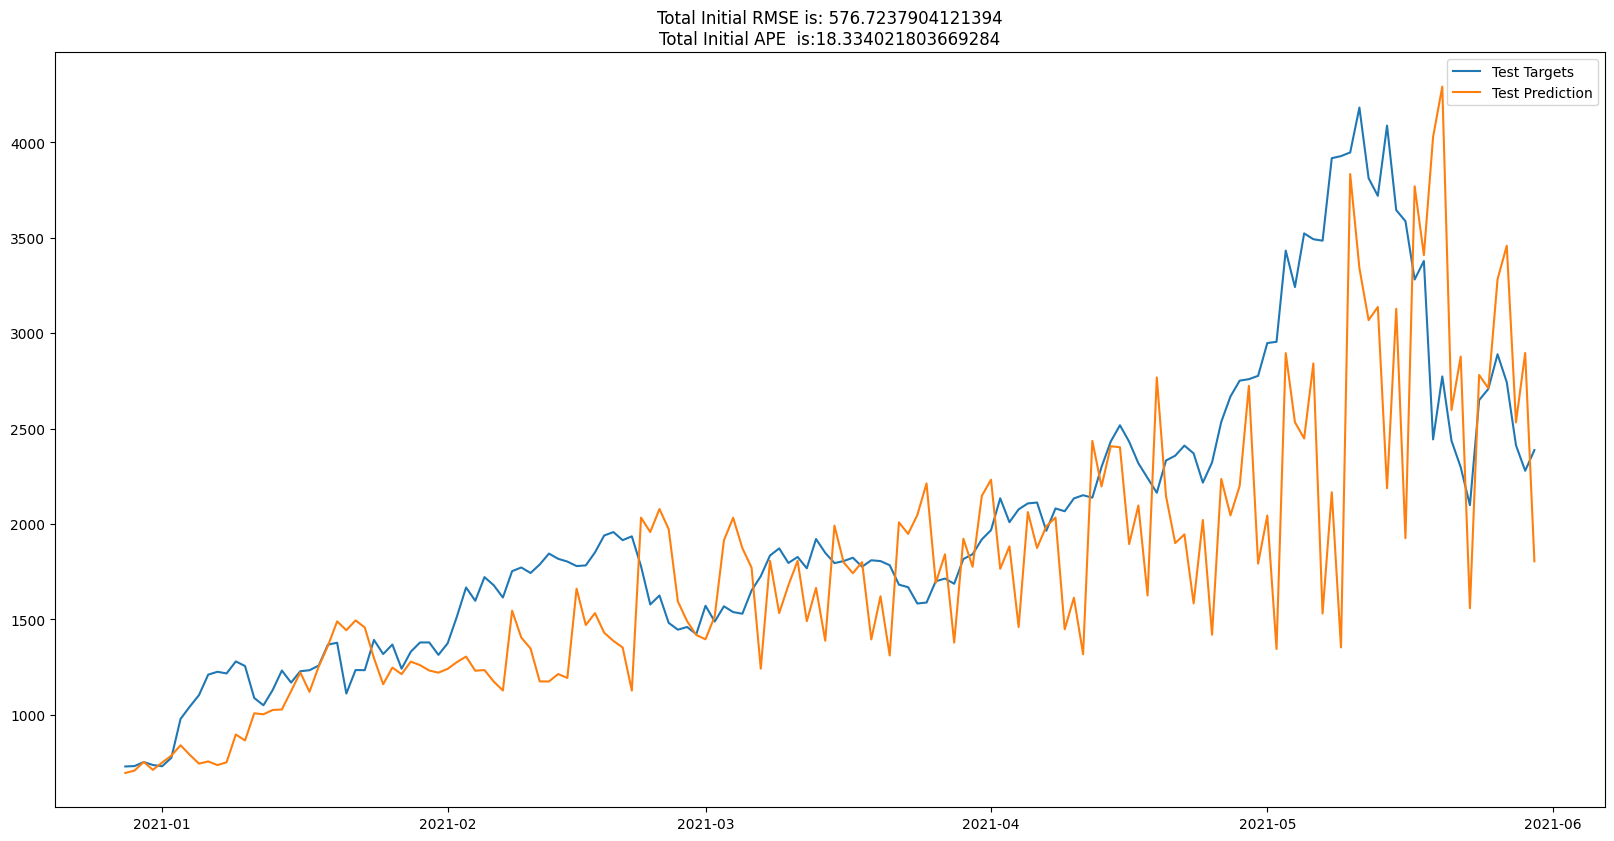

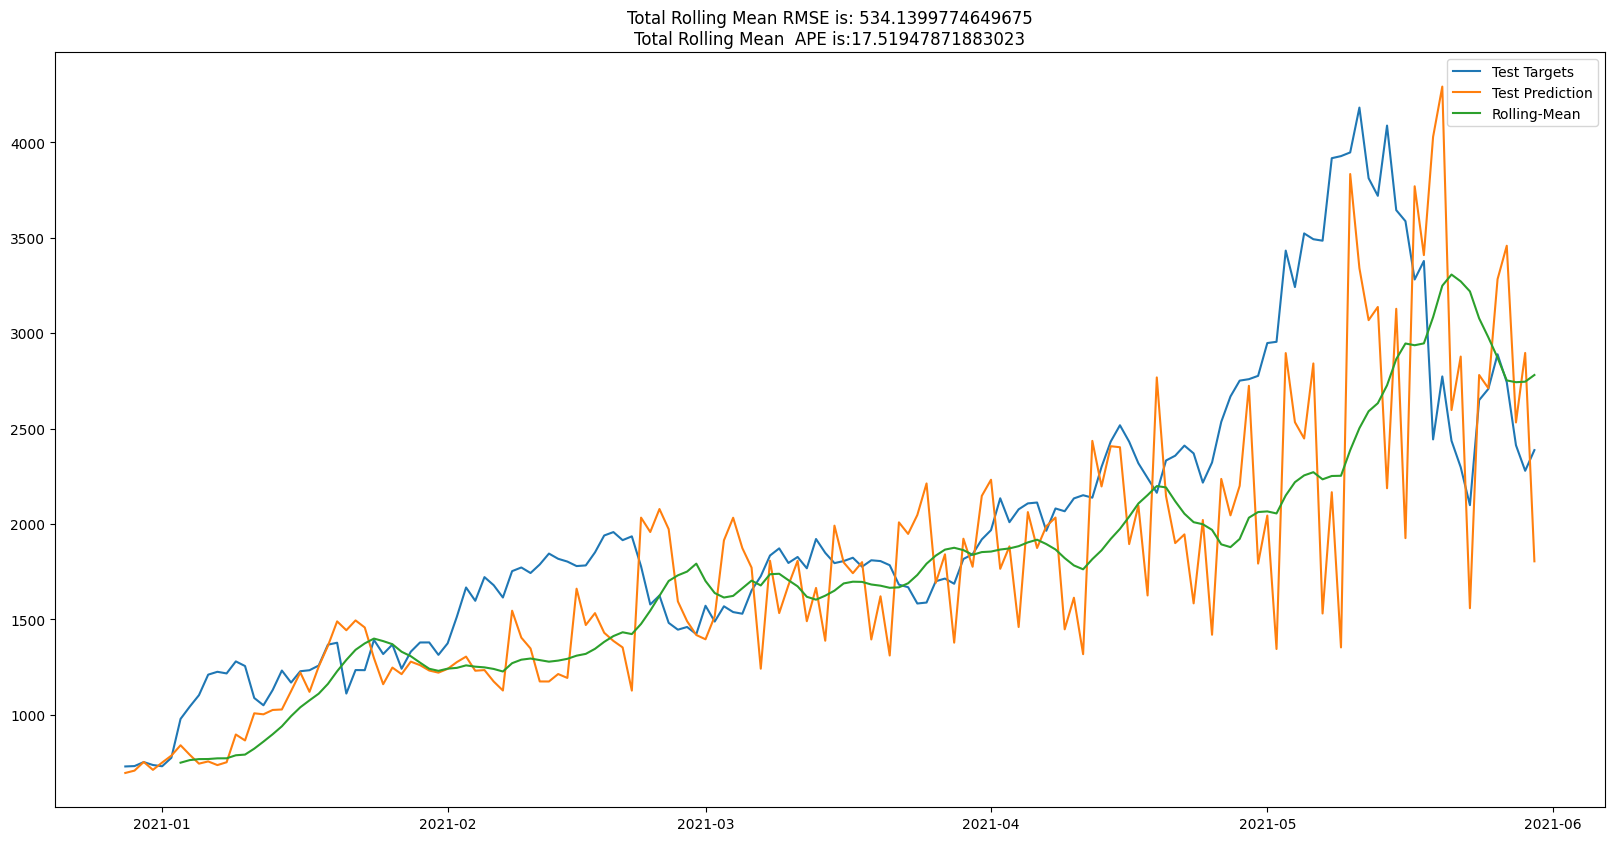

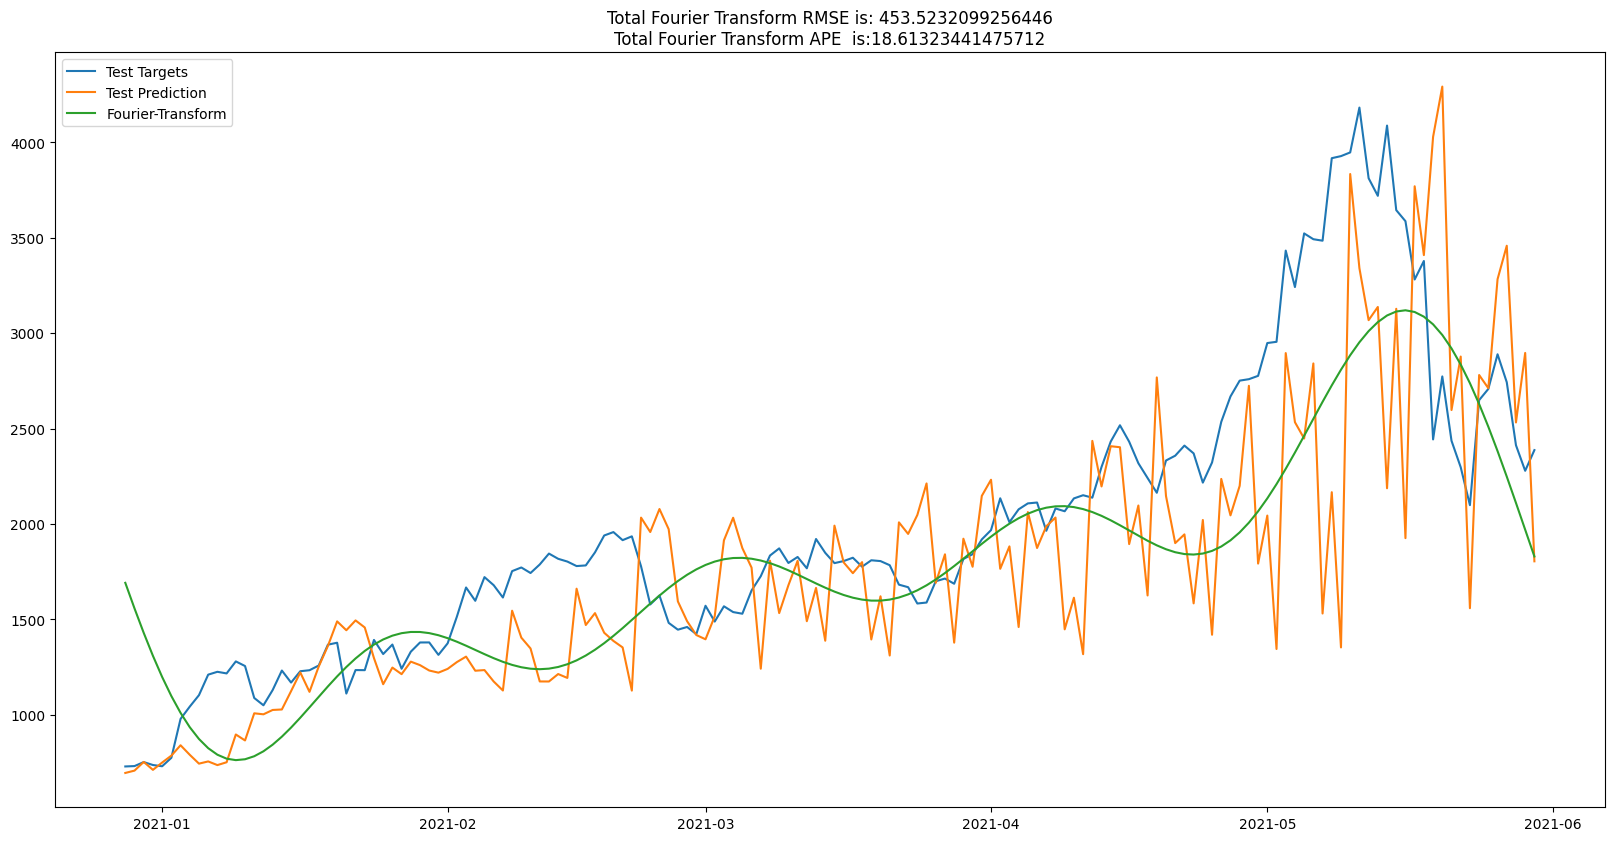

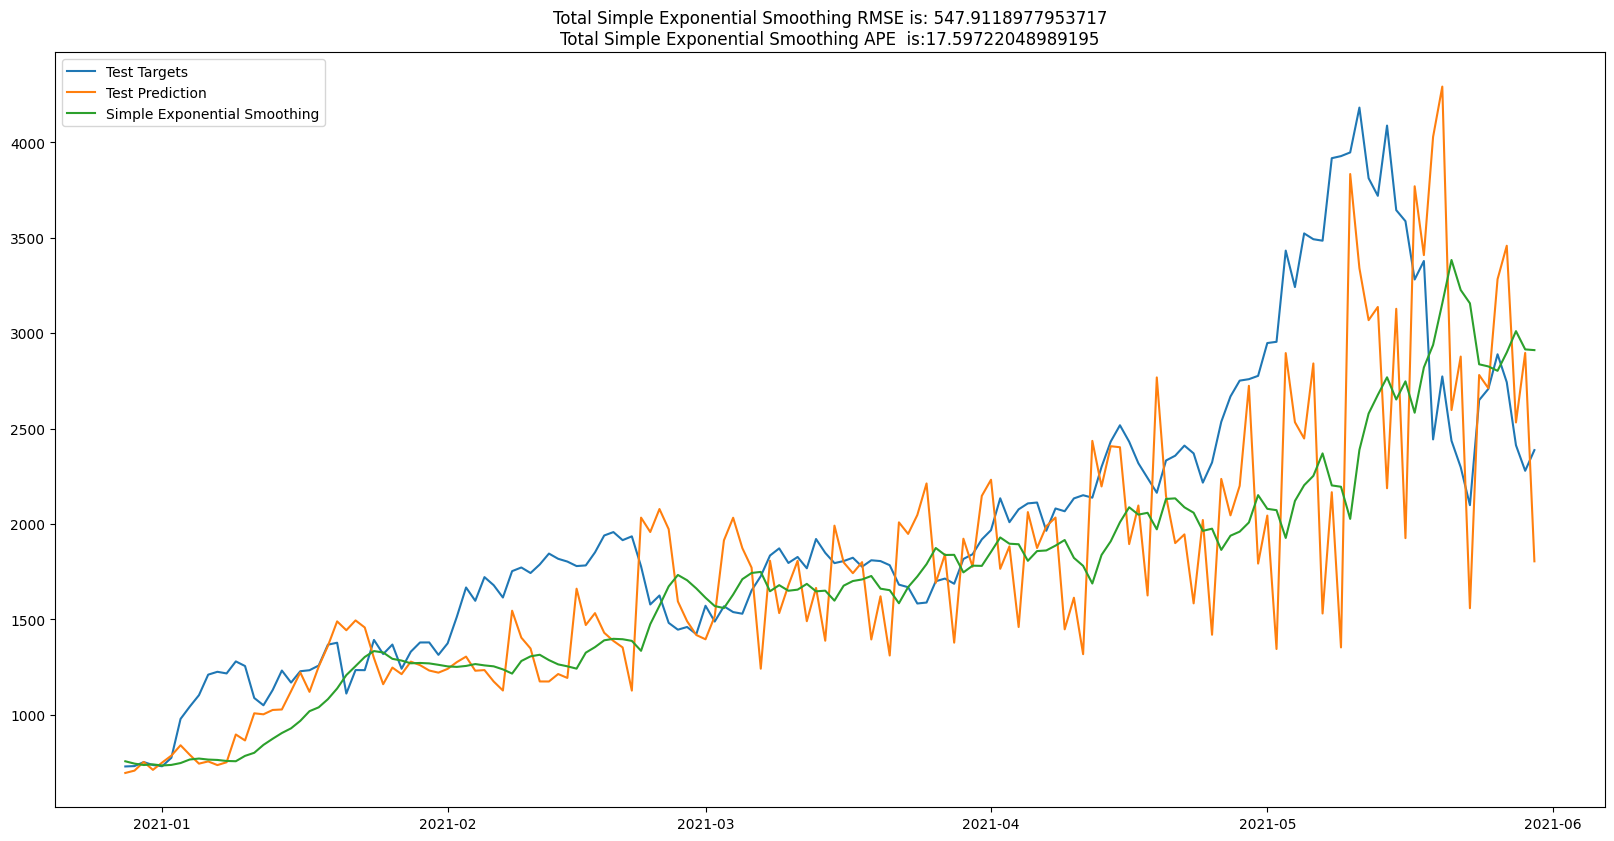

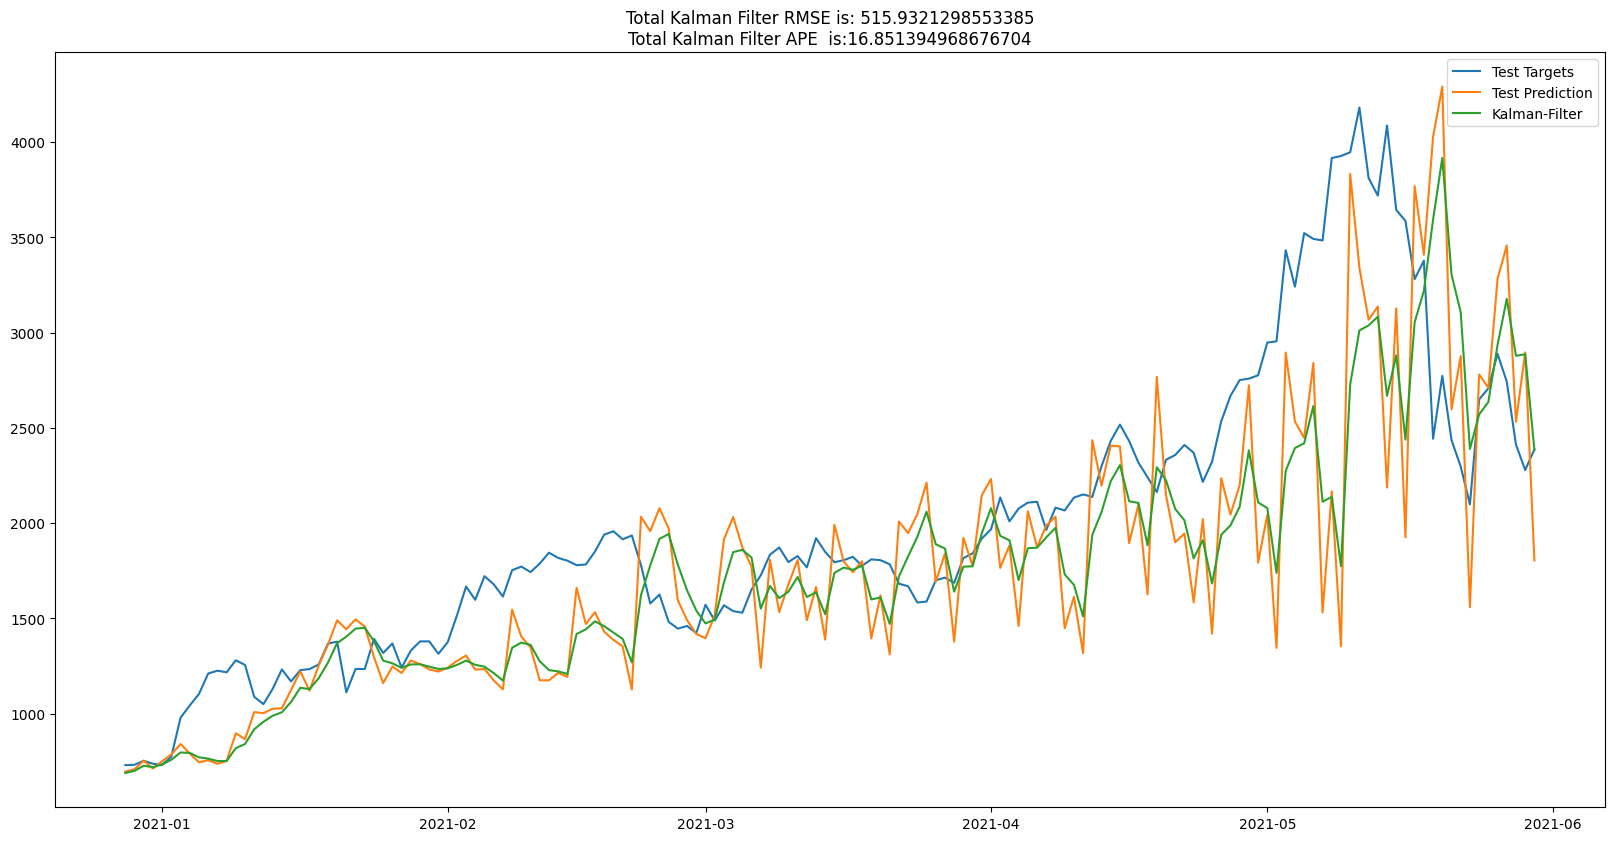

In [81]:

Init_rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
Init_ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
#print('Total Initial RMSE is: ' , Init_rmse)
#print('Total Initial APE  is: ' , Init_ape)

plt.figure(figsize=(20,10), dpi=100)
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.title(f'Total Initial RMSE is: {Init_rmse}\nTotal Initial APE  is:{Init_ape}')
plt.legend()
plt.show()



#------------------------------------------
rmseRolm = np.sqrt(np.mean((y_testrev-rolling_mean)**2))
apeRolm = np.mean(np.abs((y_testrev-rolling_mean)*100/y_testrev))
#print('Total Rolling Mean RMSE is: ' , rmseRolm)
#print('Total Rolling Mean  APE is: ' , apeRolm)

plt.figure(figsize=(20,10), dpi=100)
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, rolling_mean, label='Rolling-Mean')
plt.title(f'Total Rolling Mean RMSE is: {rmseRolm}\nTotal Rolling Mean  APE is:{apeRolm}')
plt.legend()
plt.show()



#------------------------------------------
rmseFT = np.sqrt(np.mean((y_testrev-FT)**2))
apeFT = np.mean(np.abs((y_testrev-FT)*100/y_testrev))
#print('Total Fourier Transform RMSE is: ' , rmseFT)
#print('Total Fourier Transform APE  is: ' , apeFT)

plt.figure(figsize=(20,10), dpi=100)
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, FT, label='Fourier-Transform')
plt.title(f'Total Fourier Transform RMSE is: {rmseFT}\nTotal Fourier Transform APE  is:{apeFT}')
plt.legend()
plt.show()


#------------------------------------------
rmseF2 = np.sqrt(np.mean((y_testrev-fit2.fittedvalues)**2))
apeF2 = np.mean(np.abs((y_testrev-fit2.fittedvalues)*100/y_testrev))
#print('Total Simple Exponential Smoothing RMSE is: ' , rmseF2)
#print('Total Simple Exponential Smoothing APE  is: ' , apeF2)

plt.figure(figsize=(20,10), dpi=100)
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, fit2.fittedvalues, label='Simple Exponential Smoothing')
plt.title(f'Total Simple Exponential Smoothing RMSE is: {rmseF2}\nTotal Simple Exponential Smoothing APE  is:{apeF2}')
plt.legend()
plt.show()


#------------------------------------------
rmseKF = np.sqrt(np.mean((y_testrev-states)**2))
apeKF = np.mean(np.abs((y_testrev-states)*100/y_testrev))
#print('Total Kalman Filter RMSE is: ' , rmseKF)
#print('Total Kalman Filter APE  is: ' , apeKF)

plt.figure(figsize=(20,10), dpi=100)
plt.plot(test_index, y_testrev, label='Test Targets')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, states, label='Kalman-Filter')
plt.title(f'Total Kalman Filter RMSE is: {rmseKF}\nTotal Kalman Filter APE  is:{apeKF}')
plt.legend()
plt.show()



***
# Multi-output MLP with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.078] 0.1


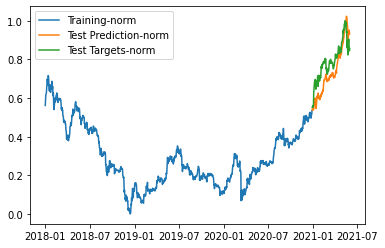

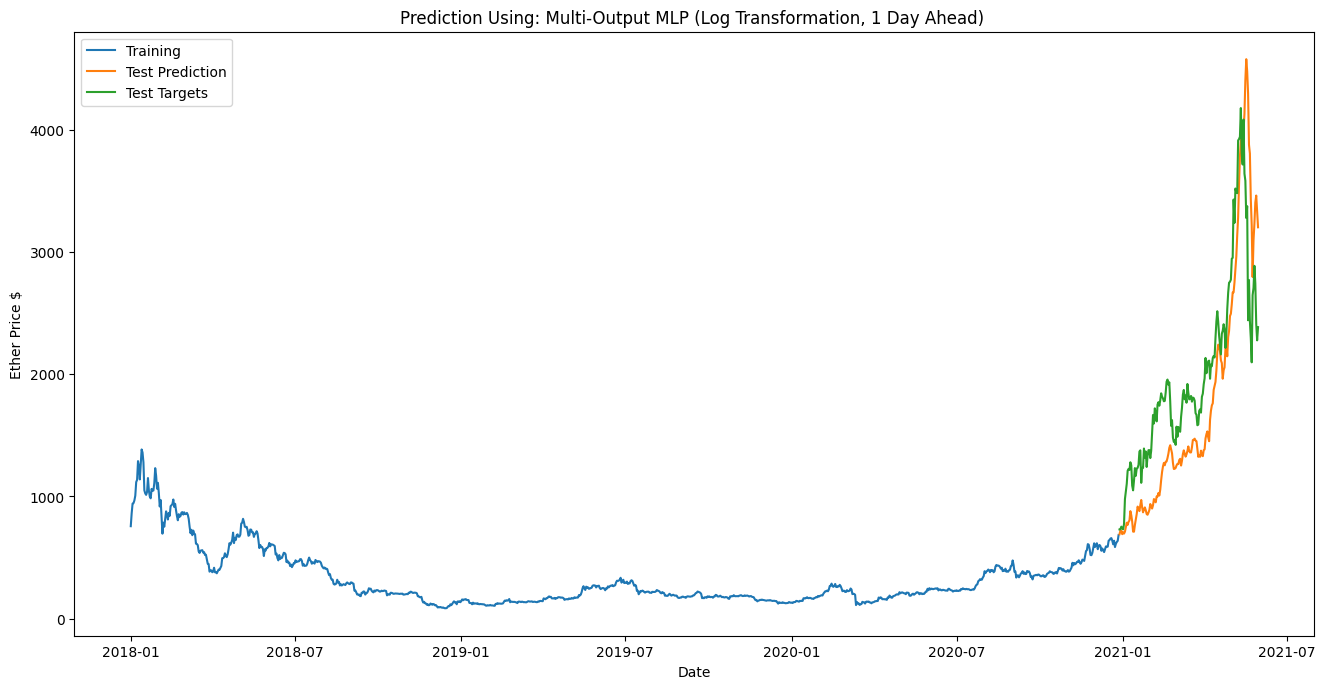

Total RMSE is:  521.8067524300866
Total APE is:  23.687648517824286
Runtime of the program is 348.3560492992401


In [50]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)


scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

n_input = 14
n_out = 1

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)


# flatten input for MLP
n_input_nn=train_x.shape[1] * train_x.shape[2]
train_x = train_x.reshape((train_x.shape[0], n_input_nn))

# separate output
Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# Define model
visible = Input(shape=(n_input_nn,))
dense1 = Dense(700, activation='relu')(visible)
dense2 = Dense(500, activation='relu')(dense1)
# define output 
output=[Dense(1)(dense2) for i in range(n_out)]
# tie together
model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_x, Y, epochs=2000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = input_x.reshape((1, input_x.shape[0] * input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    
    #yhat = [yhat[i][0][0] for i in range(7)]
    yhat = yhat[0]
    
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Output MLP (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# Multi-headed Multi-output MLP with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.034] 0.0


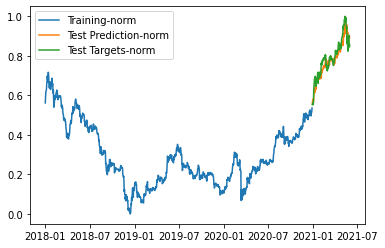

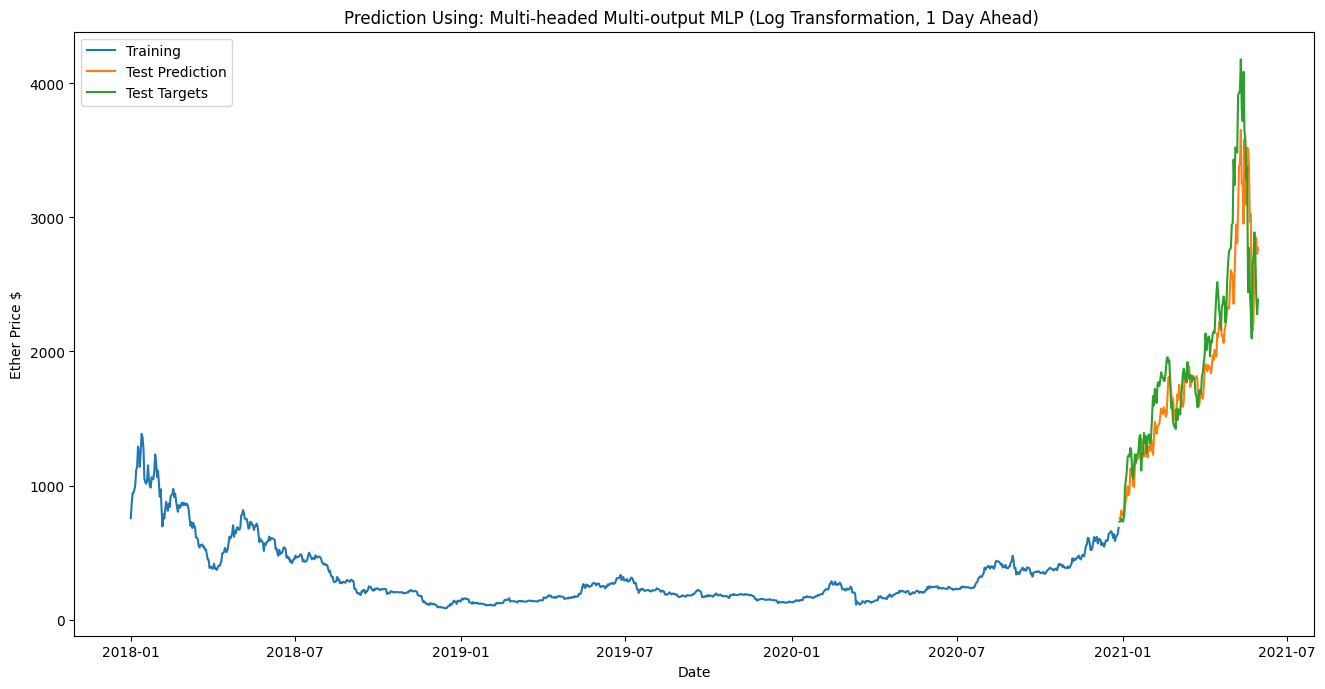

Total RMSE is:  307.94758455409857
Total APE is:  10.319234532291656
Runtime of the program is 196.89987182617188


In [59]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# separate input data
X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# first input model
visible= [Input(shape=(n_input,)) for i in range(train_x.shape[2])]
dense=[Dense(50, activation='relu')(visible[i]) for i in range(train_x.shape[2])]
# merge input models
merge = concatenate([dense[i] for i in range(train_x.shape[2])])

# output model
output=[Dense(1)(merge) for i in range(n_out)]

# tie together
model = Model(inputs=[visible[i] for i in range(train_x.shape[2])], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, Y, epochs=2000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    x=[input_x[:, i].reshape((1, n_input)) for i in range(train_x.shape[2])] 
    yhat = model.predict(x, verbose=0)
    # we only want the vector forecast
    
    #yhat = [yhat[i][0][0] for i in range(7)]
    yhat = yhat[0]
    
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-headed Multi-output MLP (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

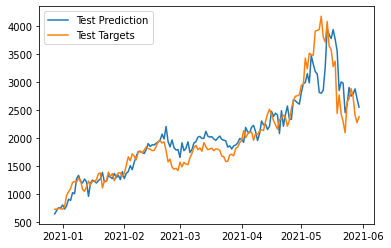

In [180]:
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.legend()
plt.show()

In [182]:
rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)

Total RMSE is:  295.0645315877184
Total APE is:  9.755952004245094
